In [19]:
%%writefile src/gaussian_blur.cpp
#include <CL/sycl.hpp>

#include "dpc_common.hpp"
#define STB_IMAGE_IMPLEMENTATION
#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"

#pragma pack(push, 1)

                    // This is the data structure which is going to represent one pixel value in RGB
                    // format
                    typedef struct
{
  unsigned char blue;
  unsigned char green;
  unsigned char red;
} rgb;

// This block is only used when build for Structure of Arays (SOA) with Array
// Notation
typedef struct
{
  unsigned char *blue;
  unsigned char *green;
  unsigned char *red;
} SOA_rgb;

#pragma pack(pop)

int *buildGaussKern(int winSize, int sigma)
{
  int wincenter, x;
  float sum = 0.0f;
  wincenter = winSize / 2;
  float *kern = (float *)malloc(winSize * sizeof(float));
  int *ikern = (int *)malloc(winSize * sizeof(int));
  float SQRT_2PI = 2.506628274631f;
  float sigmaMul2PI = 1.0f / (sigma * SQRT_2PI);
  float divSigmaPow2 = 1.0f / (2.0f * sigma * sigma);
  for (x = 0; x < wincenter + 1; x++)
  {
    kern[wincenter - x] = kern[wincenter + x] = exp(-(x * x) * divSigmaPow2) * sigmaMul2PI;
    sum += kern[wincenter - x] + ((x != 0) ? kern[wincenter + x] : 0.0);
  }
  sum = 1.0f / sum;
  for (x = 0; x < winSize; x++)
  {
    kern[x] *= sum;
    ikern[x] = kern[x] * 256.0f;
  }
  free(kern);
  return ikern;
}

void GaussBlur(rgb *pixels, unsigned int width, unsigned int height, int sigma)
{
  unsigned int winsize = (1 + (((int)ceil(3 * sigma)) * 2));
  int *gaussKern = buildGaussKern(winsize, sigma);
  unsigned int halfsize = winsize / 2;

  rgb *tmpBuffer = (rgb *)malloc(width * height * sizeof(rgb));

  for (unsigned int h = 0; h < height; h++)
  {
    unsigned int rowWidth = h * width;

    for (unsigned int w = 0; w < width; w += 1)
    {
      unsigned int rowR = 0;
      unsigned int rowG = 0;
      unsigned int rowB = 0;
      int *gaussKernPtr = gaussKern;
      int whalfsize = w + width - halfsize;
      unsigned int curPos = rowWidth + w;
      for (unsigned int k = 1; k < winsize; k += 1)
      {
        unsigned int pos = rowWidth + ((k + whalfsize) % width);
        int fkern = *gaussKernPtr++;
        rowR += (pixels[pos].red * fkern);
        rowG += (pixels[pos].green * fkern);
        rowB += (pixels[pos].blue * fkern);
      }

      tmpBuffer[curPos].red = ((unsigned char)(rowR >> 8));
      tmpBuffer[curPos].green = ((unsigned char)(rowG >> 8));
      tmpBuffer[curPos].blue = ((unsigned char)(rowB >> 8));
    }
  }
  for (unsigned int w = 0; w < width; w++)
  {
    for (unsigned int h = 0; h < height; h++)
    {
      unsigned int colR = 0;
      unsigned int colG = 0;
      unsigned int colB = 0;
      int hhalfsize = h + height - halfsize;
      for (unsigned int k = 0; k < winsize; k++)
      {
        colR += tmpBuffer[((k + hhalfsize) % height) * width + w].red * gaussKern[k];
        colG += tmpBuffer[((k + hhalfsize) % height) * width + w].green * gaussKern[k];
        colB += tmpBuffer[((k + hhalfsize) % height) * width + w].blue * gaussKern[k];
      }
      pixels[h * width + w].red = (unsigned char)(colR >> 8);
      pixels[h * width + w].green = (unsigned char)(colG >> 8);
      pixels[h * width + w].blue = (unsigned char)(colB >> 8);
    }
  }
  free(tmpBuffer);
  free(gaussKern);
}

int main(int argc, char *argv[])
{
  // 判断输入的参数是否满足要求
  if (argc < 3)
  {
    std::cout << "Program usage is <modified_program> <inputfile.bmp> "
                 "<outputfile.bmp>\n";
    return 1;
  }

  // 读取需要处理的位图数据
  int image_width = 0, image_height = 0, num_channels = 0;

  rgb *indata = (rgb *)stbi_load(argv[1],
                                 &image_width, &image_height,
                                 &num_channels, STBI_rgb);

  // 输出读取位图信息
  std::cout << "Filename: " << argv[1] << "\n"
            << "Width: " << image_width << "\n"
            << "Height: " << image_height << "\n\n";

  GaussBlur(indata, image_width, image_height, 2);

      // 输出位图
      stbi_write_bmp(argv[2], image_width, image_height, 3, indata);
  std::cout << "DCT successfully completed.\n"
            << "The processed image has been written to "
            << argv[2] << "\n";

  // 释放数据空间
  stbi_image_free(indata);
}

Overwriting src/gaussian_blur.cpp


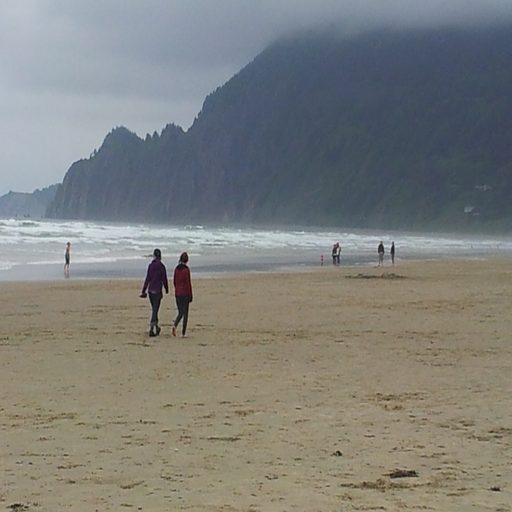

In [6]:
from PIL import Image
display(Image.open('res/nahelam512.bmp'))

In [20]:
%%writefile run_gaussian.sh
#!/bin/bash
source /opt/intel/oneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling
dpcpp src/gaussian_blur.cpp -o gaussian.out
if [ $? -eq 0 ]; then ./gaussian.out ./res/nahelam512.bmp ./res/nahelam512_blur2.bmp; fi

Overwriting run_gaussian.sh


In [ ]:
! chmod 755 q; chmod 755 run_gaussian.sh;if [ -x "$(command -v qsub)" ]; then ./q run_gaussian.sh nodes=2:gpu:ppn=2; else ./run_gaussian.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 600 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2131195.v-qsvr-1           ...ub-singleuser u173961         00:01:27 R jupyterhub     
2131250.v-qsvr-1           run_gaussian.sh  u173961                0 Q batch          

Waiting for Output 

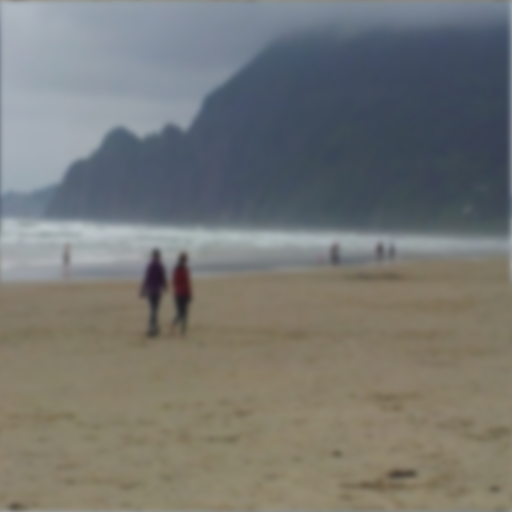

In [1]:
from PIL import Image
display(Image.open('res/nahelam512_blur2.bmp'))

## DCT 90% Reconstruct

In [28]:
%%writefile src/dct_simple90.cpp
#include <CL/sycl.hpp>
#include <cmath>
#include <cstdio>
#include <cstdlib>

#include "dpc_common.hpp"
#define STB_IMAGE_IMPLEMENTATION
#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"

#pragma pack(push, 1)

// This is the data structure which is going to represent one pixel value in RGB
// format
typedef struct
{
  unsigned char blue;
  unsigned char green;
  unsigned char red;
} rgb;

// This block is only used when build for Structure of Arays (SOA) with Array
// Notation
typedef struct
{
  unsigned char *blue;
  unsigned char *green;
  unsigned char *red;
} SOA_rgb;

#pragma pack(pop)

using namespace dpc_common;
using namespace sycl;

constexpr int block_dims = 8;
constexpr int block_size = 64;

// 创建 8x8 的DCT矩阵
void CreateDCT(float matrix[block_size])
{
  int temp[block_dims];
  for (int i = 0; i < block_dims; ++i)
    temp[i] = i;
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
    {
      if (i == 0)
        matrix[(i * block_dims) + j] = (1 / sycl::sqrt((float)block_dims));
      else
        matrix[(i * block_dims) + j] =
            sycl::sqrt((float)2 / block_dims) *
            sycl::cos(((((float)2 * temp[j]) + 1) * i * 3.14f) /
                      (2 * block_dims));
    }
  }
}

// 8x8 矩阵转置
void MatrixTranspose(float x[block_size], float xinv[block_size])
{
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
      xinv[(j * block_dims) + i] = x[(i * block_dims) + j];
  }
}

// 矩阵相乘
SYCL_EXTERNAL void MatrixMultiply(float x[block_size], float y[block_size],
                                  float xy[block_size])
{
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
    {
      xy[(i * block_dims) + j] = 0;
      for (int k = 0; k < block_dims; ++k)
        xy[(i * block_dims) + j] +=
            (x[(i * block_dims) + k] * y[(k * block_dims) + j]);
    }
  }
}

// 8x8 块上执行 DCT 算法
SYCL_EXTERNAL void ProcessBlock(rgb *indataset, rgb *outdataset,
                                float dct[block_size], float dctinv[block_size],
                                int start_index, int width)
{
  float interim[block_size], product[block_size], red_input[block_size],
      blue_input[block_size], green_input[block_size], temp[block_size];

  // 90% 量化
  float quant[64] = {3, 2, 2, 3, 5, 8, 10, 12,
                     2, 2, 3, 4, 5, 12, 12, 11,
                     3, 3, 3, 5, 8, 11, 14, 11,
                     3, 3, 4, 6, 10, 17, 16, 12,
                     4, 4, 7, 11, 14, 22, 21, 15,
                     5, 7, 11, 13, 16, 12, 23, 18,
                     10, 13, 16, 17, 21, 24, 24, 21,
                     14, 18, 19, 20, 22, 20, 20, 20};
  
  // 处理红色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    red_input[i] = indataset[start_index + pixel_index].red;
    red_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, red_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  /*
  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);
  */

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = (product[i] + 128);
    outdataset[start_index + pixel_index].red =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }

  // 处理蓝色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    blue_input[i] = indataset[start_index + pixel_index].blue;
    blue_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, blue_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = product[i] + 128;
    outdataset[start_index + pixel_index].blue =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }

  // 处理绿色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    green_input[i] = indataset[start_index + pixel_index].green;
    green_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, green_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = product[i] + 128;
    outdataset[start_index + pixel_index].green =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }
}

// 将图像划分为 8x8 块大小处理
void ProcessImage(rgb *indataset, rgb *outdataset, int width, int height)
{
  sycl::queue q(default_selector_v, exception_handler);
  std::cout << "Running on "
            << q.get_device().get_info<sycl::info::device::name>() << "\n";

  try
  {
    int image_size = width * height;
    float dct[block_size], dctinv[block_size];

    // 创建 8x8 的 DCT 矩阵
    CreateDCT(dct);
    // 创建 DCT 矩阵的转置
    MatrixTranspose(dct, dctinv);

    buffer indata_buf(indataset, range<1>(image_size));
    buffer outdata_buf(outdataset, range<1>(image_size));
    buffer dct_buf(dct, range<1>(block_size));
    buffer dctinv_buf(dctinv, range<1>(block_size));

    q.submit([&](handler &h)
             {
      auto i_acc = indata_buf.get_access(h,read_only);
      auto o_acc = outdata_buf.get_access(h);
      auto d_acc = dct_buf.get_access(h,read_only);
      auto di_acc = dctinv_buf.get_access(h,read_only);

      // 并行执行 8x8 块计算
      h.parallel_for(
          range<2>(width / block_dims, height / block_dims), [=](auto idx) {
            int start_index = idx[0] * block_dims + idx[1] * block_dims * width;
            ProcessBlock(i_acc.get_pointer(), o_acc.get_pointer(),
                         d_acc.get_pointer(), di_acc.get_pointer(), start_index,
                         width);
          }); });
    q.wait_and_throw();
  }
  catch (sycl::exception e)
  {
    std::cout << "SYCL exception caught: " << e.what() << "\n";
    exit(1);
  }
}

// 读写位图
int ReadProcessWrite(char *input, char *output)
{
  double timersecs;

  // 读取需要处理的位图数据
  int image_width = 0, image_height = 0, num_channels = 0;
  rgb *indata = (rgb *)stbi_load(input,
                                 &image_width, &image_height,
                                 &num_channels, STBI_rgb);
  // 未读取到数据
  if (!indata)
  {
    std::cout << "The input file could not be opened. Program will now exit\n";
    return 1;
  }
  else if (num_channels != 3)
  {
    std::cout
        << "The input file must be an RGB bmp image. Program will now exit\n";
    return 1;
  }
  else if (image_width % block_dims != 0 || image_height % block_dims != 0)
  {
    std::cout
        << "The input image must have dimensions which are a multiple of 8\n";
    return 1;
  }

  // 输出读取位图信息
  std::cout << "Filename: " << input << "\n"
            << " Width: " << image_width << "\n"
            << " Height: " << image_height << "\n\n";

  // 创建相同大小的输出数组
  rgb *outdata = (rgb *)malloc(image_width * image_height * sizeof(rgb));

  std::cout << "Start image processing ...\n";
  {
    TimeInterval t;
    ProcessImage(indata, outdata, image_width, image_height);
    timersecs = t.Elapsed();
  }
  std::cout << "--The processing time is " << timersecs << " seconds\n\n";

  // 输出位图
  stbi_write_bmp(output, image_width, image_height, 3, outdata);
  std::cout << "DCT successfully completed.\n"
            << "The processed image has been written to "
            << output << "\n";

  // 释放数据空间
  stbi_image_free(indata);
  std::free(outdata);

  return 0;
}

int main(int argc, char *argv[])
{
  // 判断输入的参数是否满足要求
  if (argc < 3)
  {
    std::cout << "Program usage is <modified_program> <inputfile.bmp> "
                 "<outputfile.bmp>\n";
    return 1;
  }
  return ReadProcessWrite(argv[1], argv[2]);
}

Overwriting src/dct_simple90.cpp


In [29]:
%%writefile run_90.sh
#!/bin/bash
source /opt/intel/oneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling
dpcpp src/dct_simple90.cpp -o aaa.out
if [ $? -eq 0 ]; then ./aaa.out ./res/nahelam512.bmp ./res/nahelam512_processed_90.bmp; fi

Overwriting run_90.sh


In [30]:
! chmod 755 q; chmod 755 run_90.sh;if [ -x "$(command -v qsub)" ]; then ./q run_90.sh nodes=2:gpu:ppn=2; else ./run_90.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 600 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2131195.v-qsvr-1           ...ub-singleuser u173961         00:01:34 R jupyterhub     
2131263.v-qsvr-1           run_90.sh        u173961                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████ Done⬇

########################################################################
#      Date:           Sun 15 Jan 2023 02:07:39 AM PST
#    Job ID:           2131263.v-qsvr-1.aidevcloud
#      User:           u173961
# Resources:           cput=75:00:00,neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
###############################################################

In [ ]:
! rm *.sh.*

## DCT 50% Reconstruct

In [31]:
%%writefile src/dct_simple50.cpp
#include <CL/sycl.hpp>
#include <cmath>
#include <cstdio>
#include <cstdlib>

#include "dpc_common.hpp"
#define STB_IMAGE_IMPLEMENTATION
#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"

#pragma pack(push, 1)

// This is the data structure which is going to represent one pixel value in RGB
// format
typedef struct
{
  unsigned char blue;
  unsigned char green;
  unsigned char red;
} rgb;

// This block is only used when build for Structure of Arays (SOA) with Array
// Notation
typedef struct
{
  unsigned char *blue;
  unsigned char *green;
  unsigned char *red;
} SOA_rgb;

#pragma pack(pop)

using namespace dpc_common;
using namespace sycl;

constexpr int block_dims = 8;
constexpr int block_size = 64;

// 创建 8x8 的DCT矩阵
void CreateDCT(float matrix[block_size])
{
  int temp[block_dims];
  for (int i = 0; i < block_dims; ++i)
    temp[i] = i;
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
    {
      if (i == 0)
        matrix[(i * block_dims) + j] = (1 / sycl::sqrt((float)block_dims));
      else
        matrix[(i * block_dims) + j] =
            sycl::sqrt((float)2 / block_dims) *
            sycl::cos(((((float)2 * temp[j]) + 1) * i * 3.14f) /
                      (2 * block_dims));
    }
  }
}

// 8x8 矩阵转置
void MatrixTranspose(float x[block_size], float xinv[block_size])
{
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
      xinv[(j * block_dims) + i] = x[(i * block_dims) + j];
  }
}

// 矩阵相乘
SYCL_EXTERNAL void MatrixMultiply(float x[block_size], float y[block_size],
                                  float xy[block_size])
{
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
    {
      xy[(i * block_dims) + j] = 0;
      for (int k = 0; k < block_dims; ++k)
        xy[(i * block_dims) + j] +=
            (x[(i * block_dims) + k] * y[(k * block_dims) + j]);
    }
  }
}

// 8x8 块上执行 DCT 算法
SYCL_EXTERNAL void ProcessBlock(rgb *indataset, rgb *outdataset,
                                float dct[block_size], float dctinv[block_size],
                                int start_index, int width)
{
  float interim[block_size], product[block_size], red_input[block_size],
      blue_input[block_size], green_input[block_size], temp[block_size];

  
  // 50% 量化
  float quant[64] = {16, 11, 10, 16, 24,  40,  51,  61,
                     12, 12, 14, 19, 26,  58,  60,  55,
                     14, 13, 16, 24, 40,  57,  69,  56,
                     14, 17, 22, 29, 51,  87,  80,  62,
                     18, 22, 37, 56, 68,  109, 103, 77,
                     24, 35, 55, 64, 81,  104, 113, 92,
                     49, 64, 78, 87, 103, 121, 120, 101,
                     72, 92, 95, 98, 112, 100, 103, 99 };

  // 处理红色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    red_input[i] = indataset[start_index + pixel_index].red;
    red_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, red_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = (product[i] + 128);
    outdataset[start_index + pixel_index].red =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }

  // 处理蓝色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    blue_input[i] = indataset[start_index + pixel_index].blue;
    blue_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, blue_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = product[i] + 128;
    outdataset[start_index + pixel_index].blue =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }

  // 处理绿色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    green_input[i] = indataset[start_index + pixel_index].green;
    green_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, green_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = product[i] + 128;
    outdataset[start_index + pixel_index].green =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }
}

// 将图像划分为 8x8 块大小处理
void ProcessImage(rgb *indataset, rgb *outdataset, int width, int height)
{
  sycl::queue q(default_selector_v, exception_handler);
  std::cout << "Running on "
            << q.get_device().get_info<sycl::info::device::name>() << "\n";

  try
  {
    int image_size = width * height;
    float dct[block_size], dctinv[block_size];

    // 创建 8x8 的 DCT 矩阵
    CreateDCT(dct);
    // 创建 DCT 矩阵的转置
    MatrixTranspose(dct, dctinv);

    buffer indata_buf(indataset, range<1>(image_size));
    buffer outdata_buf(outdataset, range<1>(image_size));
    buffer dct_buf(dct, range<1>(block_size));
    buffer dctinv_buf(dctinv, range<1>(block_size));

    q.submit([&](handler &h)
             {
      auto i_acc = indata_buf.get_access(h,read_only);
      auto o_acc = outdata_buf.get_access(h);
      auto d_acc = dct_buf.get_access(h,read_only);
      auto di_acc = dctinv_buf.get_access(h,read_only);

      // 并行执行 8x8 块计算
      h.parallel_for(
          range<2>(width / block_dims, height / block_dims), [=](auto idx) {
            int start_index = idx[0] * block_dims + idx[1] * block_dims * width;
            ProcessBlock(i_acc.get_pointer(), o_acc.get_pointer(),
                         d_acc.get_pointer(), di_acc.get_pointer(), start_index,
                         width);
          }); });
    q.wait_and_throw();
  }
  catch (sycl::exception e)
  {
    std::cout << "SYCL exception caught: " << e.what() << "\n";
    exit(1);
  }
}

// 读写位图
int ReadProcessWrite(char *input, char *output)
{
  double timersecs;

  // 读取需要处理的位图数据
  int image_width = 0, image_height = 0, num_channels = 0;
  rgb *indata = (rgb *)stbi_load(input,
                                 &image_width, &image_height,
                                 &num_channels, STBI_rgb);
  // 未读取到数据
  if (!indata)
  {
    std::cout << "The input file could not be opened. Program will now exit\n";
    return 1;
  }
  else if (num_channels != 3)
  {
    std::cout
        << "The input file must be an RGB bmp image. Program will now exit\n";
    return 1;
  }
  else if (image_width % block_dims != 0 || image_height % block_dims != 0)
  {
    std::cout
        << "The input image must have dimensions which are a multiple of 8\n";
    return 1;
  }

  // 输出读取位图信息
  std::cout << "Filename: " << input << "\n"
            << " Width: " << image_width << "\n"
            << " Height: " << image_height << "\n\n";

  // 创建相同大小的输出数组
  rgb *outdata = (rgb *)malloc(image_width * image_height * sizeof(rgb));

  std::cout << "Start image processing ...\n";
  {
    TimeInterval t;
    ProcessImage(indata, outdata, image_width, image_height);
    timersecs = t.Elapsed();
  }
  std::cout << "--The processing time is " << timersecs << " seconds\n\n";

  // 输出位图
  stbi_write_bmp(output, image_width, image_height, 3, outdata);
  std::cout << "DCT successfully completed.\n"
            << "The processed image has been written to "
            << output << "\n";

  // 释放数据空间
  stbi_image_free(indata);
  std::free(outdata);

  return 0;
}

int main(int argc, char *argv[])
{
  // 判断输入的参数是否满足要求
  if (argc < 3)
  {
    std::cout << "Program usage is <modified_program> <inputfile.bmp> "
                 "<outputfile.bmp>\n";
    return 1;
  }
  return ReadProcessWrite(argv[1], argv[2]);
}

Overwriting src/dct_simple50.cpp


In [32]:
%%writefile run_50.sh
#!/bin/bash
source /opt/intel/oneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling
dpcpp src/dct_simple50.cpp -o b.out
if [ $? -eq 0 ]; then ./b.out ./res/nahelam512.bmp ./res/nahelam512_processed_50.bmp; fi

Overwriting run_50.sh


In [33]:
! chmod 755 q; chmod 755 run_50.sh;if [ -x "$(command -v qsub)" ]; then ./q run_50.sh nodes=2:gpu:ppn=2; else ./run_50.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 600 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2131195.v-qsvr-1           ...ub-singleuser u173961         00:01:34 R jupyterhub     
2131264.v-qsvr-1           run_50.sh        u173961                0 Q batch          

Waiting for Output ███████████████████████ Done⬇

########################################################################
#      Date:           Sun 15 Jan 2023 02:08:40 AM PST
#    Job ID:           2131264.v-qsvr-1.aidevcloud
#      User:           u173961
# Resources:           cput=75:00:00,neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
########################################################################

## u173961 is compiling
Fi

## DCT 10% Reconstruct

In [34]:
%%writefile src/dct_simple10.cpp
#include <CL/sycl.hpp>
#include <cmath>
#include <cstdio>
#include <cstdlib>

#include "dpc_common.hpp"
#define STB_IMAGE_IMPLEMENTATION
#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"

#pragma pack(push, 1)

// This is the data structure which is going to represent one pixel value in RGB
// format
typedef struct
{
  unsigned char blue;
  unsigned char green;
  unsigned char red;
} rgb;

// This block is only used when build for Structure of Arays (SOA) with Array
// Notation
typedef struct
{
  unsigned char *blue;
  unsigned char *green;
  unsigned char *red;
} SOA_rgb;

#pragma pack(pop)

using namespace dpc_common;
using namespace sycl;

constexpr int block_dims = 8;
constexpr int block_size = 64;

// 创建 8x8 的DCT矩阵
void CreateDCT(float matrix[block_size])
{
  int temp[block_dims];
  for (int i = 0; i < block_dims; ++i)
    temp[i] = i;
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
    {
      if (i == 0)
        matrix[(i * block_dims) + j] = (1 / sycl::sqrt((float)block_dims));
      else
        matrix[(i * block_dims) + j] =
            sycl::sqrt((float)2 / block_dims) *
            sycl::cos(((((float)2 * temp[j]) + 1) * i * 3.14f) /
                      (2 * block_dims));
    }
  }
}

// 8x8 矩阵转置
void MatrixTranspose(float x[block_size], float xinv[block_size])
{
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
      xinv[(j * block_dims) + i] = x[(i * block_dims) + j];
  }
}

// 矩阵相乘
SYCL_EXTERNAL void MatrixMultiply(float x[block_size], float y[block_size],
                                  float xy[block_size])
{
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
    {
      xy[(i * block_dims) + j] = 0;
      for (int k = 0; k < block_dims; ++k)
        xy[(i * block_dims) + j] +=
            (x[(i * block_dims) + k] * y[(k * block_dims) + j]);
    }
  }
}

// 8x8 块上执行 DCT 算法
SYCL_EXTERNAL void ProcessBlock(rgb *indataset, rgb *outdataset,
                                float dct[block_size], float dctinv[block_size],
                                int start_index, int width)
{
  float interim[block_size], product[block_size], red_input[block_size],
      blue_input[block_size], green_input[block_size], temp[block_size];

  // 10% 量化
  float quant[64] = {80,  60,  50,  80,  120, 200, 255, 255,
                     55,  60,  70,  95,  130, 255, 255, 255,
                     70,  65,  80,  120, 200, 255, 255, 255,
                     70,  85,  110, 145, 255, 255, 255, 255,
                     90,  110, 185, 255, 255, 255, 255, 255,
                     120, 175, 255, 255, 255, 255, 255, 255,
                     245, 255, 255, 255, 255, 255, 255, 255,
                     255, 255, 255, 255, 255, 255, 255, 255 };

  // 处理红色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    red_input[i] = indataset[start_index + pixel_index].red;
    red_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, red_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = (product[i] + 128);
    outdataset[start_index + pixel_index].red =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }

  // 处理蓝色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    blue_input[i] = indataset[start_index + pixel_index].blue;
    blue_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, blue_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = product[i] + 128;
    outdataset[start_index + pixel_index].blue =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }

  // 处理绿色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    green_input[i] = indataset[start_index + pixel_index].green;
    green_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, green_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = product[i] + 128;
    outdataset[start_index + pixel_index].green =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }
}

// 将图像划分为 8x8 块大小处理
void ProcessImage(rgb *indataset, rgb *outdataset, int width, int height)
{
  sycl::queue q(default_selector_v, exception_handler);
  std::cout << "Running on "
            << q.get_device().get_info<sycl::info::device::name>() << "\n";

  try
  {
    int image_size = width * height;
    float dct[block_size], dctinv[block_size];

    // 创建 8x8 的 DCT 矩阵
    CreateDCT(dct);
    // 创建 DCT 矩阵的转置
    MatrixTranspose(dct, dctinv);

    buffer indata_buf(indataset, range<1>(image_size));
    buffer outdata_buf(outdataset, range<1>(image_size));
    buffer dct_buf(dct, range<1>(block_size));
    buffer dctinv_buf(dctinv, range<1>(block_size));

    q.submit([&](handler &h)
             {
      auto i_acc = indata_buf.get_access(h,read_only);
      auto o_acc = outdata_buf.get_access(h);
      auto d_acc = dct_buf.get_access(h,read_only);
      auto di_acc = dctinv_buf.get_access(h,read_only);

      // 并行执行 8x8 块计算
      h.parallel_for(
          range<2>(width / block_dims, height / block_dims), [=](auto idx) {
            int start_index = idx[0] * block_dims + idx[1] * block_dims * width;
            ProcessBlock(i_acc.get_pointer(), o_acc.get_pointer(),
                         d_acc.get_pointer(), di_acc.get_pointer(), start_index,
                         width);
          }); });
    q.wait_and_throw();
  }
  catch (sycl::exception e)
  {
    std::cout << "SYCL exception caught: " << e.what() << "\n";
    exit(1);
  }
}

// 读写位图
int ReadProcessWrite(char *input, char *output)
{
  double timersecs;

  // 读取需要处理的位图数据
  int image_width = 0, image_height = 0, num_channels = 0;
  rgb *indata = (rgb *)stbi_load(input,
                                 &image_width, &image_height,
                                 &num_channels, STBI_rgb);
  // 未读取到数据
  if (!indata)
  {
    std::cout << "The input file could not be opened. Program will now exit\n";
    return 1;
  }
  else if (num_channels != 3)
  {
    std::cout
        << "The input file must be an RGB bmp image. Program will now exit\n";
    return 1;
  }
  else if (image_width % block_dims != 0 || image_height % block_dims != 0)
  {
    std::cout
        << "The input image must have dimensions which are a multiple of 8\n";
    return 1;
  }

  // 输出读取位图信息
  std::cout << "Filename: " << input << "\n"
            << " Width: " << image_width << "\n"
            << " Height: " << image_height << "\n\n";

  // 创建相同大小的输出数组
  rgb *outdata = (rgb *)malloc(image_width * image_height * sizeof(rgb));

  std::cout << "Start image processing ...\n";
  {
    TimeInterval t;
    ProcessImage(indata, outdata, image_width, image_height);
    timersecs = t.Elapsed();
  }
  std::cout << "--The processing time is " << timersecs << " seconds\n\n";

  // 输出位图
  stbi_write_bmp(output, image_width, image_height, 3, outdata);
  std::cout << "DCT successfully completed.\n"
            << "The processed image has been written to "
            << output << "\n";

  // 释放数据空间
  stbi_image_free(indata);
  std::free(outdata);

  return 0;
}

int main(int argc, char *argv[])
{
  // 判断输入的参数是否满足要求
  if (argc < 3)
  {
    std::cout << "Program usage is <modified_program> <inputfile.bmp> "
                 "<outputfile.bmp>\n";
    return 1;
  }
  return ReadProcessWrite(argv[1], argv[2]);
}

Overwriting src/dct_simple10.cpp


In [36]:
%%writefile run_10.sh
#!/bin/bash
source /opt/intel/oneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling
dpcpp src/dct_simple10.cpp -o c.out
if [ $? -eq 0 ]; then ./c.out ./res/nahelam512.bmp ./res/nahelam512_processed_10.bmp; fi

Overwriting run_10.sh


In [37]:
! chmod 755 q; chmod 755 run_10.sh;if [ -x "$(command -v qsub)" ]; then ./q run_10.sh nodes=2:gpu:ppn=2; else ./run_10.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 600 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2131195.v-qsvr-1           ...ub-singleuser u173961         00:01:36 R jupyterhub     
2131265.v-qsvr-1           run_10.sh        u173961                0 Q batch          

Waiting for Output ██████████████████████████████ Done⬇

########################################################################
#      Date:           Sun 15 Jan 2023 02:09:03 AM PST
#    Job ID:           2131265.v-qsvr-1.aidevcloud
#      User:           u173961
# Resources:           cput=75:00:00,neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
########################################################################

## u173961 is compi

In [40]:
%%writefile src/dct.cpp
#include <CL/sycl.hpp>
#include <cmath>
#include <cstdio>
#include <cstdlib>

#include "dpc_common.hpp"
#define STB_IMAGE_IMPLEMENTATION
#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"

#pragma pack(push, 1)

// This is the data structure which is going to represent one pixel value in RGB
// format
typedef struct
{
  unsigned char blue;
  unsigned char green;
  unsigned char red;
} rgb;

// This block is only used when build for Structure of Arays (SOA) with Array
// Notation
typedef struct
{
  unsigned char *blue;
  unsigned char *green;
  unsigned char *red;
} SOA_rgb;

#pragma pack(pop)

using namespace dpc_common;
using namespace sycl;

constexpr int block_dims = 8;
constexpr int block_size = 64;

// 创建 8x8 的DCT矩阵
void CreateDCT(float matrix[block_size])
{
  int temp[block_dims];
  for (int i = 0; i < block_dims; ++i)
    temp[i] = i;
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
    {
      if (i == 0)
        matrix[(i * block_dims) + j] = (1 / sycl::sqrt((float)block_dims));
      else
        matrix[(i * block_dims) + j] =
            sycl::sqrt((float)2 / block_dims) *
            sycl::cos(((((float)2 * temp[j]) + 1) * i * 3.14f) /
                      (2 * block_dims));
    }
  }
}

// 8x8 矩阵转置
void MatrixTranspose(float x[block_size], float xinv[block_size])
{
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
      xinv[(j * block_dims) + i] = x[(i * block_dims) + j];
  }
}

// 矩阵相乘
SYCL_EXTERNAL void MatrixMultiply(float x[block_size], float y[block_size],
                                  float xy[block_size])
{
  for (int i = 0; i < block_dims; ++i)
  {
    for (int j = 0; j < block_dims; ++j)
    {
      xy[(i * block_dims) + j] = 0;
      for (int k = 0; k < block_dims; ++k)
        xy[(i * block_dims) + j] +=
            (x[(i * block_dims) + k] * y[(k * block_dims) + j]);
    }
  }
}

// 8x8 块上执行 DCT 算法
SYCL_EXTERNAL void ProcessBlock(rgb *indataset, rgb *outdataset,
                                float dct[block_size], float dctinv[block_size],
                                int start_index, int width)
{
  float interim[block_size], product[block_size], red_input[block_size],
      blue_input[block_size], green_input[block_size], temp[block_size];

  // 90% 量化
  float quant[64] = {3, 2, 2, 3, 5, 8, 10, 12,
                     2, 2, 3, 4, 5, 12, 12, 11,
                     3, 3, 3, 5, 8, 11, 14, 11,
                     3, 3, 4, 6, 10, 17, 16, 12,
                     4, 4, 7, 11, 14, 22, 21, 15,
                     5, 7, 11, 13, 16, 12, 23, 18,
                     10, 13, 16, 17, 21, 24, 24, 21,
                     14, 18, 19, 20, 22, 20, 20, 20};
  
  // 处理红色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    red_input[i] = indataset[start_index + pixel_index].red;
    red_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, red_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  
  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = (product[i] + 128);
    outdataset[start_index + pixel_index].red =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }

  // 处理蓝色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    blue_input[i] = indataset[start_index + pixel_index].blue;
    blue_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, blue_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  for (int i = 0; i < block_size; ++i)
    interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = product[i] + 128;
    outdataset[start_index + pixel_index].blue =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }

  // 处理绿色通道

  // 转换像素范围从 [0, 255] 到 [-128, 127]
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    green_input[i] = indataset[start_index + pixel_index].green;
    green_input[i] -= 128;
  }

  // 计算DCT
  MatrixMultiply(dct, green_input, temp);
  MatrixMultiply(temp, dctinv, interim);

  // 使用量化矩阵舍弃高频数据
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] / quant[i]) + 0.5f);

  // 反量化
  //for (int i = 0; i < block_size; ++i)
  //  interim[i] = sycl::floor((interim[i] * quant[i]) + 0.5f);

  // 计算IDCT
  MatrixMultiply(dctinv, interim, temp);
  MatrixMultiply(temp, dct, product);

  // 转换像素范围写入输出图片
  for (int i = 0; i < block_size; ++i)
  {
    int pixel_index = i / block_dims * width + i % block_dims;
    float temp = product[i] + 128;
    outdataset[start_index + pixel_index].green =
        (temp > 255.f) ? 255 : (unsigned char)temp;
  }
}

// 将图像划分为 8x8 块大小处理
void ProcessImage(rgb *indataset, rgb *outdataset, int width, int height)
{
  sycl::queue q(default_selector_v, exception_handler);
  std::cout << "Running on "
            << q.get_device().get_info<sycl::info::device::name>() << "\n";

  try
  {
    int image_size = width * height;
    float dct[block_size], dctinv[block_size];

    // 创建 8x8 的 DCT 矩阵
    CreateDCT(dct);
    // 创建 DCT 矩阵的转置
    MatrixTranspose(dct, dctinv);

    buffer indata_buf(indataset, range<1>(image_size));
    buffer outdata_buf(outdataset, range<1>(image_size));
    buffer dct_buf(dct, range<1>(block_size));
    buffer dctinv_buf(dctinv, range<1>(block_size));

    q.submit([&](handler &h)
             {
      auto i_acc = indata_buf.get_access(h,read_only);
      auto o_acc = outdata_buf.get_access(h);
      auto d_acc = dct_buf.get_access(h,read_only);
      auto di_acc = dctinv_buf.get_access(h,read_only);

      // 并行执行 8x8 块计算
      h.parallel_for(
          range<2>(width / block_dims, height / block_dims), [=](auto idx) {
            int start_index = idx[0] * block_dims + idx[1] * block_dims * width;
            ProcessBlock(i_acc.get_pointer(), o_acc.get_pointer(),
                         d_acc.get_pointer(), di_acc.get_pointer(), start_index,
                         width);
          }); });
    q.wait_and_throw();
  }
  catch (sycl::exception e)
  {
    std::cout << "SYCL exception caught: " << e.what() << "\n";
    exit(1);
  }
}

// 读写位图
int ReadProcessWrite(char *input, char *output)
{
  double timersecs;

  // 读取需要处理的位图数据
  int image_width = 0, image_height = 0, num_channels = 0;
  rgb *indata = (rgb *)stbi_load(input,
                                 &image_width, &image_height,
                                 &num_channels, STBI_rgb);
  // 未读取到数据
  if (!indata)
  {
    std::cout << "The input file could not be opened. Program will now exit\n";
    return 1;
  }
  else if (num_channels != 3)
  {
    std::cout
        << "The input file must be an RGB bmp image. Program will now exit\n";
    return 1;
  }
  else if (image_width % block_dims != 0 || image_height % block_dims != 0)
  {
    std::cout
        << "The input image must have dimensions which are a multiple of 8\n";
    return 1;
  }

  // 输出读取位图信息
  std::cout << "Filename: " << input << "\n"
            << " Width: " << image_width << "\n"
            << " Height: " << image_height << "\n\n";

  // 创建相同大小的输出数组
  rgb *outdata = (rgb *)malloc(image_width * image_height * sizeof(rgb));

  std::cout << "Start image processing ...\n";
  {
    TimeInterval t;
    ProcessImage(indata, outdata, image_width, image_height);
    timersecs = t.Elapsed();
  }
  std::cout << "--The processing time is " << timersecs << " seconds\n\n";

  // 输出位图
  stbi_write_bmp(output, image_width, image_height, 3, outdata);
  std::cout << "DCT successfully completed.\n"
            << "The processed image has been written to "
            << output << "\n";

  // 释放数据空间
  stbi_image_free(indata);
  std::free(outdata);

  return 0;
}

int main(int argc, char *argv[])
{
  // 判断输入的参数是否满足要求
  if (argc < 3)
  {
    std::cout << "Program usage is <modified_program> <inputfile.bmp> "
                 "<outputfile.bmp>\n";
    return 1;
  }
  return ReadProcessWrite(argv[1], argv[2]);
}

Overwriting src/dct.cpp


In [41]:
%%writefile run.sh
#!/bin/bash
source /opt/intel/oneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling
dpcpp src/dct.cpp -o dct.out
if [ $? -eq 0 ]; then ./dct.out ./res/nahelam512_blur2.bmp ./res/nahelam512_blur2_processed.bmp; fi

Overwriting run.sh


In [42]:
! chmod 755 q; chmod 755 run.sh;if [ -x "$(command -v qsub)" ]; then ./q run.sh nodes=2:gpu:ppn=2; else ./run.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 600 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2131195.v-qsvr-1           ...ub-singleuser u173961         00:01:42 R jupyterhub     
2131268.v-qsvr-1           run.sh           u173961                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████ Done⬇

########################################################################
#      Date:           Sun 15 Jan 2023 02:13:39 AM PST
#    Job ID:           2131268.v-qsvr-1.aidevcloud
#      User:           u173961
# Resources:           cput=75:00:00,neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
###############################################################